## A도시 범죄발생현황 분석

### 분석 목표 설정
- 범죄 발생 추이 (연도별)
- 범죄 유형별 분포 (절도, 폭력, 성범죄, 마약 등)
- 범죄 발생 시간대 분석 (심야/새벽 집중 여부)

### 분석 진행 
- 두 데이터를 시간대별로 일관된 형태로 정규화
- 연도별로 합쳐서 분석 가능한 구조로 변환
- 죄유형별 시간대별 경향 분석 및 시각화

In [4]:
### 데이터 로드
import pandas as pd

file_path = "A도시_범죄발생현황.xlsx"
excel_file = pd.ExcelFile(file_path)

sheet_names = excel_file.sheet_names
df_2019_2022 = excel_file.parse('2019-2022')
df_2023 = excel_file.parse('2023')
df_2019_2022.head(), df_2023.head()

(     연도   항목  심     야(0시-4시)  새     벽(4시-7시)  오     전(7시-12시)  \
 0  2019  강력범              20               7                7   
 1  2019  절도범             121              31              152   
 2  2019  폭력범             252              25              131   
 3  2019  지능범            1131              16              193   
 4  2019  풍속범               7               0                4   
 
    오     후(12시-18시)  초 저 녁(18시-20시)  밤(20시-24시)  
 0                13               4          17  
 1               299              95         151  
 2               175              78         215  
 3               272              60          71  
 4                 5               1           6  ,
      연도   항목  00:00~02:59  03:00~05:59  06:00~08:59  09:00~11:59  12:00~14:59  \
 0  2023  강력범           39            9            4            9            6   
 1  2023  절도범          236           67          100          152          197   
 2  2023  폭력범          308           48          

In [5]:
### 두개 시트 데이터를 정규화
df_2019_2022.columns = ['연도', '범죄유형', '심야(0~4)', '새벽(4~7)', '오전(7~12)', '오후(12~18)', '초저녁(18~20)', '밤(20~24)']
df19_22_melted = df_2019_2022.melt(id_vars=['연도', '범죄유형'], 
                                   var_name='시간대', value_name='발생건수')

# 2023 시트도 유사하게 변환
df_2023.columns = ['연도', '범죄유형', '00:00~02:59', '03:00~05:59', '06:00~08:59', '09:00~11:59',
                   '12:00~14:59', '15:00~17:59', '18:00~20:59', '21:00~23:59', '미상']
df23_melted = df_2023.melt(id_vars=['연도', '범죄유형'], 
                           var_name='시간대', value_name='발생건수')

# 두 데이터 프레임 병합 전, 시간대 형식 통일을 위해 2023 데이터를 그룹핑
시간대_매핑 = {
    '00:00~02:59': '심야(0~4)', '03:00~05:59': '심야(0~4)',
    '06:00~08:59': '새벽(4~7)', '09:00~11:59': '오전(7~12)',
    '12:00~14:59': '오후(12~18)', '15:00~17:59': '오후(12~18)',
    '18:00~20:59': '초저녁(18~20)', '21:00~23:59': '밤(20~24)'
}

# 미상은 분석에서 제외
df23_filtered = df23_melted[df23_melted['시간대'] != '미상'].copy()
df23_filtered['시간대'] = df23_filtered['시간대'].map(시간대_매핑)

# 시간대와 범죄유형 기준으로 합산
df23_grouped = df23_filtered.groupby(['연도', '범죄유형', '시간대'], as_index=False)['발생건수'].sum()

# 2019~2022 + 2023 합치기
df_all = pd.concat([df19_22_melted, df23_grouped], ignore_index=True)

# 결과 확인
df_all.head(10)

,연도,범죄유형,시간대,발생건수
0,2019,강력범,심야(0~4),20
1,2019,절도범,심야(0~4),121
2,2019,폭력범,심야(0~4),252
3,2019,지능범,심야(0~4),1131
4,2019,풍속범,심야(0~4),7
5,2019,기타형법범,심야(0~4),223
6,2019,특별법범,심야(0~4),616
7,2020,강력범,심야(0~4),37
8,2020,절도범,심야(0~4),193
9,2020,폭력범,심야(0~4),232


### 범죄유형별 시간대 발생 분포 (전체 합산 기준)

In [7]:
### 그래프 한글 표기 
import platform
from matplotlib import font_manager, rc

def set_font():
    if platform.system() == 'Darwin':     # IOS
        rc('font', family='AppleGothic')
    elif platform.system() == 'Windows':
        path = "c:/Windows/Fonts/malgun.ttf"
        font_name = font_manager.FontProperties(fname=path).get_name()
        rc('font', family=font_name)
    elif platform.system() == 'Linux':
        path = "/usr/share/fonts/truetype/freefont/malgun.ttf"
        font_name = font_manager.FontProperties(fname=path).get_name()
        rc('font', family=font_name)
    else:
        print('Unknown system... sorry~~~~') 

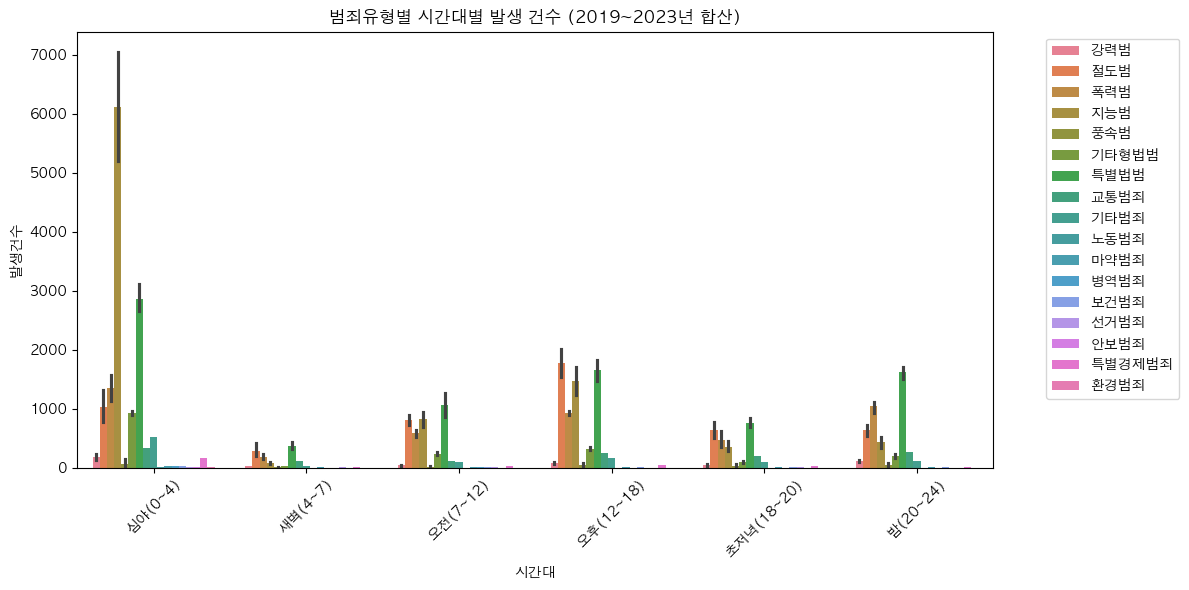

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

set_font()

# 전체 범죄유형별 시간대 분포 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=df_all, x='시간대', y='발생건수', hue='범죄유형', estimator='sum')
plt.title('범죄유형별 시간대별 발생 건수 (2019~2023년 합산)')
plt.ylabel('발생건수')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()